# Generate joint samples of prior predictive distribution for Euler-Bernoulli beam


<img src="BeamDrawing.png" width=300px>

### Model Formulation:

Let $u(x)$ denote the vertical deflection of the beam and let $f(x)$ denote the vertical force acting on the beam at point $x$ (positive for upwards, negative for downwards).  We assume the displacement of the beam can be well approximated using Euler-Bernoulli beam theory and thus satisfies the PDE
$$
\frac{\partial^2}{\partial x^2}\left[ \exp[m(x)] \frac{\partial^2 u}{\partial x^2}\right] = f(x),
$$
where $E(x)=\exp[m(x)]$ is an effective stiffness that depends both on the beam geometry and material properties.  Our goal is to infer the log stiffness $m(x)$ given a few point observations of $u(x)$ and a known load $f(x)$.

The left end of beam is fixed and has boundary conditions
$$
u(x=0) = 0,\quad \left.\frac{\partial u}{\partial x}\right|_{x=0} = 0.
$$
The right end of the beam is free and has boundary conditions
$$
\left.\frac{\partial^2 u}{\partial x^2}\right|_{x=L} = 0, \quad  \left.\frac{\partial^3 u}{\partial x^3}\right|_{x=L} = 0.
$$

We assume that $m(x)$ is piecwise constant over $P$ nonoverlapping intervals on $[0,L]$.  More precisely,
$$
m(x) = \sum_{i=1}^P m_i \,I\left(x\in [a_i, a_{i+1})\right),
$$
where $I(\cdot)$ is an indicator function.  With this piecewise constant assumption, our goal is then to characterize the 

### Prior
For the prior over the piecewise constant values $m_i$, we assume each variable is independent and normally distributed, i.e., 
$$
m_i \sim N(\mu_i, \sigma_i^2).
$$

### Likelihood
Let $N_x$ denote the number of finite difference nodes used to discretize the Euler-Bernoulli PDE above.  For this problem, we will have observations of the solution $u(x)$ at a smaller number $N_y$ of the finite difference nodes.  Let $u\in\mathbb{R}^{N_x}$ denote a vector containing the finite difference solution and let $y\in\mathbb{R}^{N_y}$ denote the observable random variable, which is the solution $u$ at $N_y$ nodes plus some noise $\epsilon$, i.e.
$$
y = Bu + \epsilon,
$$
where $\epsilon \sim N(0, \Sigma_y)$ and $B$ is a sparse matrix that extracts the values of $u$ at the $N_y$ points.  The solution vector $u$ is given by
$$
u = [K(m)]^{-1}f,
$$
where $K$ represents the discretization of the Euler-Bernoulli PDE as a function of $m$.  Combining this with the definition of $y$, we have the complete forward model
$$
y = B[K(m)]^{-1} f + \epsilon.
$$

The likelihood function then takes the form:
$$
p(y | m) = N\left(\, B [K(m)]^{-1} f,\,\,\Sigma_y \,\right) 
$$

### Joint Distribution
The joint distribution over $m$ and $y$ is given by $p(y,m) = p(y|m)p(m)$.  To generate a sample of the joint distribution, we first generate a sample $m^{(i)}$ of the prior $p(m)$ and then generate a sample $y^{(i)}$ from $p(y|m^{(i)})$, which involves solving $B[K(m^{(i))}]^{-1} f$ and then adding a random realization of $\epsilon$.

## Imports

In [1]:
import pandas as pd

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import h5py

import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
from pandas.plotting import scatter_matrix
import pandas as pd

## Problem settings

In [2]:
# Discretization
numPts = 31

# Standard deviatino of the additivate Gaussian noise
noiseStd = 1e-3

# Prior mean and variance 
priorMu = 8.0
priorStd = 1.0

# Beam parameters
length = 1.0
radius = 0.1

# Node locations
x = np.linspace(0,length,numPts)

# We will take every numSkip node of the solution as an observation location
numSkip = 5
numObs = int(np.floor(float(numPts-1)/numSkip))

In [3]:
numParamBlocks = 3
blockSize = int(float(numPts)/numParamBlocks)

blockInds = [None]*numParamBlocks
for i in range(numParamBlocks-1):
    blockInds[i] = np.arange(i*blockSize,(i+1)*blockSize)
blockInds[-1] = np.arange((numParamBlocks-1)*blockSize, numPts)

## Set up the beam model
For the interior nodes, second order finite difference approximations to the derivatives yields:
$$
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1}-2u_i+u_{i-1}}{\delta x^2}
$$
which then implies
$$
\frac{\partial^2}{\partial x^2}\left[k(x) \frac{\partial^2 u}{\partial x^2}\right] \approx \frac{1}{\delta x^2}\left[k_{i+1}\frac{u_{i+2}-2u_{i+1}+u_{i}}{\delta x^2} - 2k_{i}\frac{u_{i+1}-2u_{i}+u_{i-1}}{\delta x^2} + k_{i-1}\frac{u_{i}-2u_{i-1}+u_{i-2}}{\delta x^2}\right] = \frac{1}{\delta x^4}\left[k_{i+1}u_{i+2} - 2(k_{i+1}+k_i)u_{i+1} + (k_{i+1}+4k_i+k_{i-1})u_{i} - 2(k_i+k_{i-1}) u_{i-1} + k_{i-1} u_{i-2}\right]
$$.

One node in from the left boundary, we have the boundary condition
$$
\frac{\partial u}{\partial x} = 0,
$$
which we need to use in our finite difference discretization.  Consider the one sided second order approximation
$$
\frac{\partial^2}{\partial x^2}\left[k(x) \frac{\partial^2 u}{\partial x^2}\right] \approx \frac{1}{\delta x^2}\left[2k(x_1)\left.\frac{\partial^2 u}{\partial x^2}\right|_{x_1} - 5k(x_2)\left.\frac{\partial^2 u}{\partial x^2}\right|_{x_2} + 4k(x_3)\left.\frac{\partial^2 u}{\partial x^2}\right|_{x_3}-k(x_4)\left.\frac{\partial^2 u}{\partial x^2}\right|_{x_4}\right]
$$
The boundary condition implies
$$
\left.\frac{\partial^2 u}{\partial x^2}\right|_{x_1} \approx \frac{1}{2\delta x}\left[\left.\frac{\partial u}{\partial x}\right|_{x_2} - \left.\frac{\partial u}{\partial x}\right|_{x_0}\right] \approx \frac{u_3-u_1}{4\delta x^2},
$$
which can be combined with standard finite difference estimates of the second derivatives to obtain
$$
\frac{\partial^2}{\partial x^2}\left[k(x) \frac{\partial^2 u}{\partial x^2}\right] \approx \frac{1}{\delta x^4}\left[\frac{1}{2}k_1(u_3-u_1) - 5k_2(u_3-2u_2+u_1) + 4k_3(u_2-2u_3+u_4)-k_4(u_5-2u_4+u_3)\right] = \frac{1}{\delta x^4}\left[(-\frac{1}{2}k_1-5k_2)u_1 + (10k_2+4k_3)u_2 + (\frac{1}{2}k_1-5k_2-8k_3-k_4)u_3 + (4k_3+2k_4)u_4 -k_4u_5\right]
$$

In [4]:
class BeamModel:
    
    def __init__(self, x, length=1.0, radius=0.1):
        self.x = x
        self.moi = np.pi/4.0*radius**4 # Moment of inertia of beam
        
        self.load = -0.1*np.ones((numPts,))
        self.load[0] = 0 # Needed to enforce the Dirichlet BC on the left
        self.load[1] = 0 # Needed to enforce the zero derivative BC on the left
        
    def Solve(self, modulus):
        
        K = self.BuildStiffness(modulus)
        u = spla.spsolve(K, self.load/self.moi,use_umfpack=True)
        return u
    
    def BuildStiffness(self,modulus):
        """ Construct the sparse stiffness matrix given a vector containing exp(m)
            at every finite difference node
        """
        dx = self.x[1]-self.x[0]
        numPts = self.x.shape[0]

        dx4 = dx**4

        # Create stiffness matrix
        rows = []
        cols = []
        vals = []
        #K = np.zeros((numPts, numPts))

        # Build stiffness matrix (center)
        for i in range(2, numPts-2):
            rows.append(i)
            cols.append(i+2)
            vals.append(modulus[i+1] / dx4)

            rows.append(i)
            cols.append(i+1)
            vals.append(-2.0*(modulus[i+1] + modulus[i]) / dx4)

            rows.append(i)
            cols.append(i)
            vals.append((modulus[i+1] + 4.0*modulus[i] + modulus[i-1]) / dx4)

            rows.append(i)
            cols.append(i-1)
            vals.append(-2.0*(modulus[i] + modulus[i-1]) / dx4)

            rows.append(i)
            cols.append(i-2)
            vals.append(modulus[i-1] / dx4)


        # Set row i == 1
        rows.append(1)
        cols.append(1)
        vals.append((-0.5*modulus[1]-5*modulus[2]) / dx4)

        rows.append(1)
        cols.append(2)
        vals.append((10.0*modulus[2] + 4.0*modulus[3])/dx4)

        rows.append(1)
        cols.append(3)
        vals.append((0.5*modulus[1]-5.0*modulus[2]-8.0*modulus[3]-modulus[4])/dx4)

        rows.append(1)
        cols.append(4)
        vals.append((4.0*modulus[3] + 2.0*modulus[4])/dx4)

        rows.append(1)
        cols.append(5)
        vals.append(-modulus[4]/dx4)

        rows.append(numPts-2)
        cols.append(numPts-1)
        vals.append((modulus[numPts-1] - 4.0*modulus[numPts-2] + modulus[numPts-3])/dx4)

        rows.append(numPts-2)
        cols.append(numPts-2)
        vals.append((-2.0*modulus[numPts-1] + 9.0*modulus[numPts-2] - 2.0*modulus[numPts-3])/dx4)

        rows.append(numPts-2)
        cols.append(numPts-3)
        vals.append((modulus[numPts-1] - 6.0*modulus[numPts-2] + modulus[numPts-3])/dx4)

        rows.append(numPts-2)
        cols.append(numPts-4)
        vals.append(modulus[numPts-2]/dx4)

        rows.append(numPts-1)
        cols.append(numPts-1)
        vals.append(2.0*modulus[numPts-1]/dx4)

        rows.append(numPts-1)
        cols.append(numPts-2)
        vals.append(-4.0*modulus[numPts-1] / dx4)

        rows.append(numPts-1)
        cols.append(numPts-3)
        vals.append(2.0*modulus[numPts-1]/dx4)

        # Apply dirichlet BC (w=0 at x=0)
        rows.append(0)
        cols.append(0)
        vals.append(1)

        return sp.csr_matrix((vals,(rows,cols)), shape=(numPts,numPts)) 

### Plot an example of observed data

In [5]:
beam = BeamModel(x,length,radius)

modulus = np.exp(priorMu*np.ones(numPts))
u = beam.Solve(modulus)

xobs = x[0::numSkip][1:]
uobs = u[0::numSkip][1:] + noiseStd*np.random.randn(numObs)

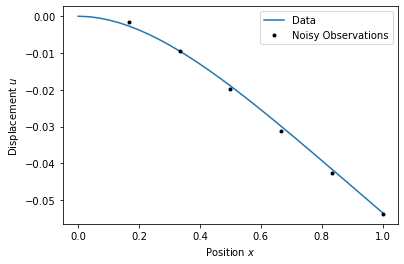

In [6]:
plt.plot(x,u,label='Data')
plt.plot(xobs,uobs,'.k',label='Noisy Observations')
plt.xlabel('Position $x$')
plt.ylabel('Displacement $u$')
plt.legend()
plt.show()

## Generate random samples

In [7]:
numSamps = 50000

samps = np.zeros((numSamps, numParamBlocks+numObs))
for sampInd in range(numSamps):
    samps[sampInd, 0:numParamBlocks] = priorMu + priorStd*np.random.randn(1,numParamBlocks)
    
    modulus = np.zeros(numPts)
    for block in range(numParamBlocks):
        modulus[blockInds[block]] = np.exp(samps[sampInd,block])
    
    u = beam.Solve(modulus)
    samps[sampInd,numParamBlocks:] = u[0::numSkip][1:] + noiseStd*np.random.randn(1,numObs)

In [8]:
# Save the samples to an HDF5 file
import h5py
fout = h5py.File('BeamSamples.h5','w')
fout['/Samples'] = samps
fout['/Samples'].attrs['Radius'] = radius
fout['/Samples'].attrs['Length'] = length
fout['/Samples'].attrs['x'] = x
fout['/Samples'].attrs['Number of Stiffness Parameters'] = numParamBlocks
fout['/Samples'].attrs['Prior Mean'] = priorMu
fout['/Samples'].attrs['Prior Std'] = priorStd
fout['/Samples'].attrs['Noise Std'] = noiseStd
fout.close()

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
file = h5py.File('BeamSamples.h5','r')
samps = np.array(file['/Samples'])

<Figure size 1080x1080 with 0 Axes>

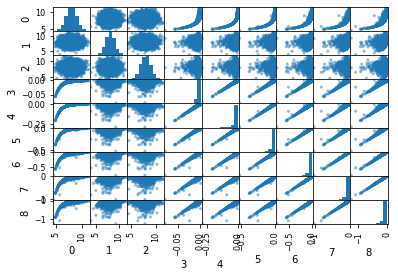

In [10]:
plt.figure(figsize=(15,15))
scatter_matrix(pd.DataFrame(samps[::10,:]))
plt.show()

In [11]:
# Standard deviatino of the additivate Gaussian noise
# noiseStd = 1e-3
# Prior mean and variance 
# priorMu = 8.0
# priorStd = 1.0

# MCMC MH sampling

# going to add Gaussian noise with potentially difference variances
# to vector of there parameters m =[m1,m2,m3]
# y = [y1,...,y6] is fixed observable 
# want to compare to using RTO-MH with generative NN
#  at what number of parameters and observables is it faster 
#  to use RTO-MH with realNVP ?

In [25]:
from tqdm import trange
niters = int(1e5)
n_param = 3 # number of parameters 
n_obs = 6
init_val = 8*np.ones((n_param,1))+0.01*np.random.rand(n_param,1)
m_y_joint = samps[0,:]
y_given = np.reshape(m_y_joint[n_param:],(n_obs,1))

def target(m_vector,y_given):

    modulus = np.zeros(numPts)
    for i in range(numParamBlocks):
           modulus[blockInds[i]] = np.exp(m_vector[i])
    u = beam.Solve(modulus)
    y_mean = np.reshape(u[0::numSkip][1:],(n_obs,1))
    cov_y_inv = noiseStd**(-2)*np.eye(n_obs)
    p_y_m = -0.5*np.transpose(y_given-y_mean)@cov_y_inv@(y_given-y_mean)
    
    m_mean = priorMu*np.ones((n_param,1))
    cov_m_inv = priorStd**(-2)*np.eye(n_param)
    p_m = -0.5*np.transpose(m_vector-m_mean)@cov_m_inv@(m_vector-m_mean)
    
    return p_y_m+p_m

def MCMC(niters,b,init_val,n_param,y_given):
    # niters: number of interations of MCMC
    # b: variance of the proposal Gaussian density for X1

    naccept=0
    theta = init_val # initial value for the Markov chain

    samples = np.zeros((n_param,niters+1)) # in shape of (parameter,batch)
    samples[:,0] = np.reshape(theta,(n_param,))
    t0 = time.time()
    for i in trange(niters):
        theta_p = theta + np.random.randn(n_param,1)*b;
        rho = np.exp(target(theta_p,y_given)-target(theta,y_given))
        u = np.random.uniform()
        if u < rho:
            naccept += 1
            theta = theta_p
        samples[:,i+1] = np.reshape(theta,(n_param,))
    acceptance_rate = naccept/niters
    tf = time.time()
    total_time = tf-t0
    return acceptance_rate, samples, total_time

acc_rate, samples, total_time = MCMC(niters=niters,b=0.2,init_val=init_val,n_param=n_param,y_given=y_given)
print('acc_rate:',acc_rate, 'time:', total_time)

100%|██████████| 100000/100000 [01:38<00:00, 1018.64it/s]

acc_rate: 0.25678 time: 98.172367811203


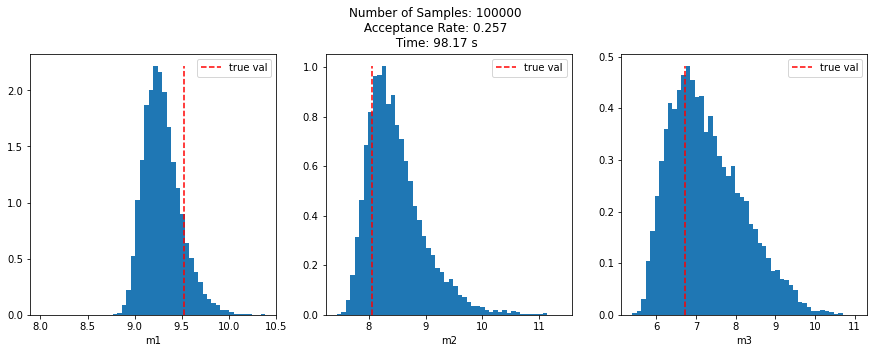

In [26]:
X = np.transpose(samples)
fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(m_y_joint[:n_param])
counts,bins = np.histogram(X[:,0],50,density=True)
axs[0].hist(bins[:-1],bins,weights=counts)
x = np.linspace(m1,m1,100)
y = np.linspace(0,max(counts),100)
axs[0].plot(x,y,'r--',label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()
counts,bins = np.histogram(X[:,1],50,density=True)
axs[1].hist(bins[:-1],bins,weights=counts)
x = np.linspace(m2,m2,100)
y = np.linspace(0,max(counts),100)
axs[1].plot(x,y,'r--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()
counts,bins = np.histogram(X[:,2],50,density=True)
plt.hist(bins[:-1],bins,weights=counts)
x = np.linspace(m3,m3,100)
y = np.linspace(0,max(counts),100)
axs[2].plot(x,y,'r--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()
plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f \n Time: %0.2f s'%(niters,acc_rate,total_time))
plt.subplots_adjust(top=0.85)

plt.savefig('Euler_Beam_MCMC_samples.png')

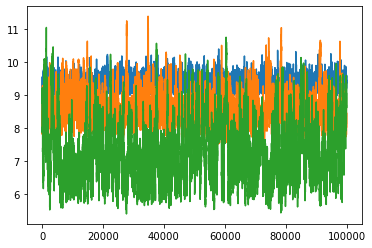

In [27]:
plt.plot(X[:,:])